In [1]:
# Question 4
import pandas as pd 
import numpy as np
import nltk
import re

In [2]:
df_merged = pd.read_csv("data/merged_file.csv")
df_cmu = pd.read_csv("dataset/cmu_merged_with_imdb.csv")

print(df_cmu.columns)

Index(['IMDbID', 'MovieName', 'MovieReleaseDate', 'MovieBoxOfficeRevenue',
       'MovieRuntime', 'MovieLanguages', 'MovieCountries', 'PlotSummaries',
       'averageRating', 'genres', 'Category'],
      dtype='object')


In [3]:
from textblob import TextBlob

# Sentiment Analysis Function
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply Function to DataFrame
df_cmu['sentiment_score'] = df_cmu.PlotSummaries.apply(analyze_sentiment)

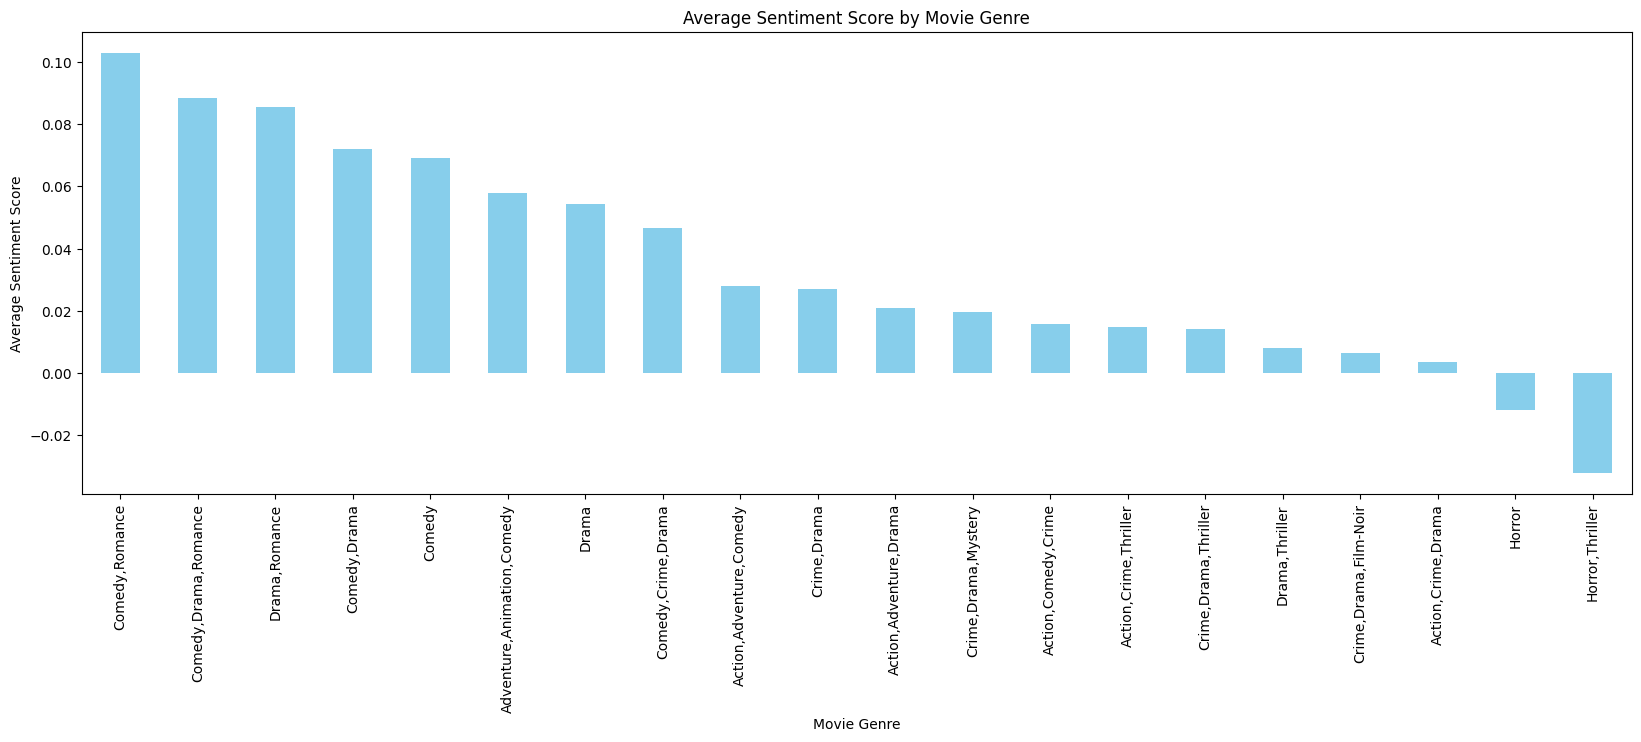

In [4]:
import matplotlib.pyplot as plt
# Preprocessing MovieGenre column (splitting in case of multiple genres and stacking them)
genres_expanded = df_cmu['genres'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
genres_expanded.name = 'SingleGenre'

# Join the expanded genres back to the original dataframe
df_expanded = df_cmu.join(genres_expanded)

# Calculate average sentiment score for each genre
genre_sentiment = df_expanded.groupby('SingleGenre')['sentiment_score'].mean()

# Identify the most frequent genres
top_genres = df_expanded['SingleGenre'].value_counts().head(20).index

# Filter average sentiment by the most frequent genres
top_genre_sentiment = genre_sentiment[top_genres].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(20,6))
top_genre_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Movie Genre')
plt.xlabel('Movie Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()

In [5]:
war_movies = df_cmu[df_cmu['genres'].str.contains('war', case=False, na=False)]
war_movies

,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres,Category,sentiment_score
18,tt0046757,Beachhead,1954,1400000.0,90.0,None,United States of America,"{{Expand section}} In late October 1943, a bat...",5.7,"Drama,War",Non Socio-Political,0.175000
43,tt0065825,Hell Boats,1970,NaN,95.0,English,United States of America,"In 1941 Lt. Commander Jeffords, an American se...",5.5,"Drama,War",Non Socio-Political,-0.084011
67,tt0017850,The Enemy,1927,NaN,90.0,Silent film,United States of America,Newlywed Carl goes to war where he endures ma...,7.5,"Drama,Romance,War",Socio-Political,0.031250
76,tt1918969,Amar Bondhu Rashed,2011,NaN,NaN,Bengali,NaN,Story of a boy named Ibu during Liberation war...,8.3,War,Socio-Political,0.045833
118,tt0119173,G.I. Jane,1997,97169156.0,125.0,English,United States of America,A Senate Armed Services Committee interviews a...,6.0,"Action,Drama,War",Non Socio-Political,-0.055848
...,...,...,...,...,...,...,...,...,...,...,...,...
14672,tt0037197,The Purple Heart,1944,NaN,99.0,English,United States of America,In April 1942 the crew of a downed American B-...,6.5,"Drama,History,War",Socio-Political,-0.042216
14688,tt0037058,Medal for the General,1944,NaN,84.0,English,United Kingdom,"The title character is Victor Church, a World ...",6.7,"Drama,War",Socio-Political,-0.119394
14751,tt0055401,Samson,1961,NaN,117.0,Polish,Poland,"A dark coming-of-age film, Samson follows its ...",6.3,"Drama,Romance,War",Non Socio-Political,0.004993
14854,tt1239427,Brothers at War,2009,NaN,110.0,English,United States of America,Jake Rademacher states at the beginning of the...,6.4,"Documentary,War",Socio-Political,-0.006250


In [6]:
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch

# Load pre-trained BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

# Function to handle long texts by splitting into chunks
def get_bert_embeddings(text, chunk_size=512):
    # Tokenize input text
    tokens = tokenizer.tokenize(text)
    # Initialize an empty array to store embeddings
    all_embeddings = []
    # Process text in chunks
    for i in range(0, len(tokens), chunk_size-2):  # subtract 2 for [CLS] and [SEP] tokens
        # Prepare tokens for input to BERT
        chunk_tokens = tokens[i:i+chunk_size-2]
        chunk_tokens = ['[CLS]'] + chunk_tokens + ['[SEP]']
        chunk_ids = tokenizer.convert_tokens_to_ids(chunk_tokens)
        chunk_ids_tensor = torch.tensor([chunk_ids]).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Get BERT embeddings for the chunk
        with torch.no_grad():
            chunk_embeddings = model(chunk_ids_tensor).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        all_embeddings.append(chunk_embeddings)

    # Aggregate the embeddings by averaging
    embeddings = np.mean(all_embeddings, axis=0)
    return embeddings

# Apply the function to your dataset
war_movies['bert_embeddings'] = war_movies['PlotSummaries'].apply(get_bert_embeddings)

# Dimensionality Reduction
pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(list(war_movies['bert_embeddings']))

# Clustering
kmeans = KMeans(n_clusters=5)
war_movies['topic'] = kmeans.fit_predict(X_reduced)



/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_44765/3498790533.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_movies['bert_embeddings'] = war_movies['PlotSummaries'].apply(get_bert_embeddings)
/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_44765/3498790533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_movies['topic'] = kmeans.fit_predict(X_reduced)


In [ ]:
import spacy
spacy.cli.download("en_core_web_sm")

Cluster 0:
ghetto, 1.5652123678269478
movie, 1.5417081538001378
family, 1.4604268503062214
world, 1.4142607879386855
john, 1.398255854443358
japanese, 1.3782515697939872
men, 1.363361796660611
friends, 1.357882368463125
story, 1.3573513371365473
soldiers, 1.2867698332544941


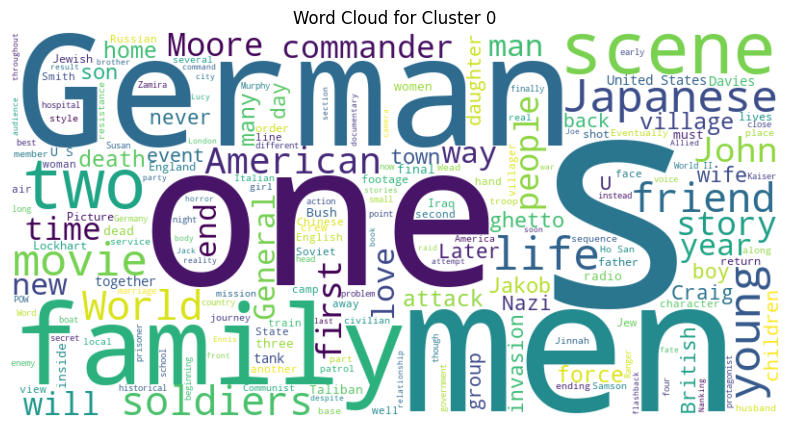

Cluster 1:
japanese, 4.668425336409353
men, 3.5168307952234352
soldiers, 2.8100603931714496
family, 2.7056918149412277
father, 2.6013745455384485
mother, 2.5456925136061455
camp, 2.333115418208378
later, 2.295170140448816
new, 2.1477961955634814
away, 2.043049195831265


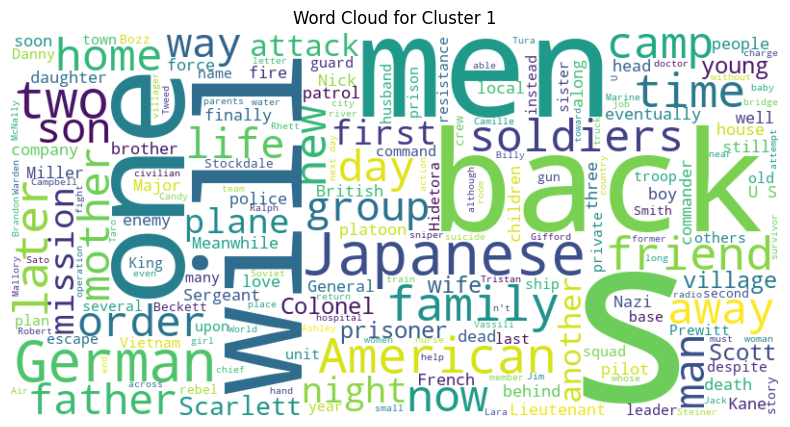

Cluster 2:
german, 5.736236128980049
soldiers, 3.5947995050323738
men, 3.2265720840587577
von, 3.2205435394354427
british, 2.9161887909846818
japanese, 2.8997209397931343
sergeant, 2.8604783583862443
french, 2.8114713660996937
germans, 2.757460264982608
american, 2.7552110908024745


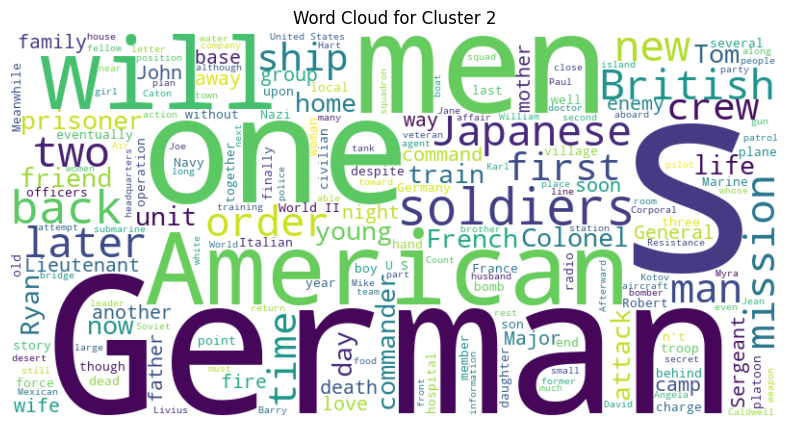

Cluster 3:
american, 2.5614732123265425
world, 2.3969240265804435
ii, 1.476146664584789
british, 1.2830203221771657
love, 1.2294129031438936
spies, 1.1935157675135208
german, 1.072288985992695
japanese, 1.0687055967559898
korean, 1.0654444674348134
allied, 1.0416357359415707


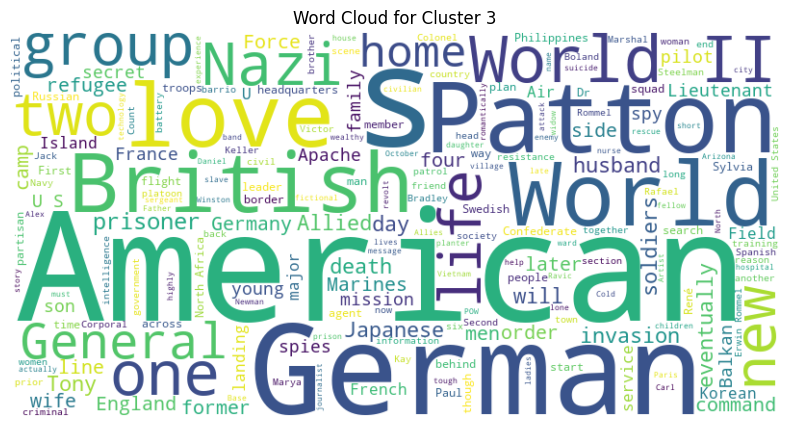

Cluster 4:
world, 1.4726578157123633
story, 1.4208427251797326
priest, 1.2768503084204554
section, 1.2309681840110762
korean, 1.2248383549470594
com, 1.2159584432464337
synopsis, 1.1936753496418517
iraq, 1.1079927798577391
love, 1.062564421603453
ii, 0.97361224286667


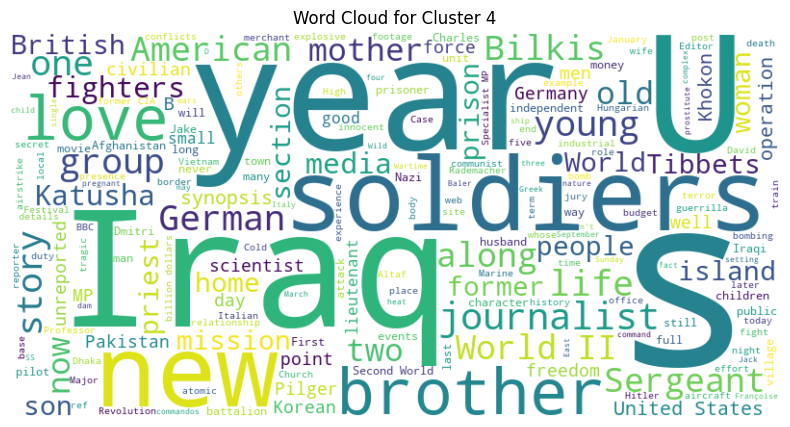

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from nltk.corpus import stopwords
import spacy

# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Custom function to filter out verbs and custom stop words
custom_stop_words = {'war', 'soldier', 'military', 'army', 'film', 'army', 'battle', 'combat', 'conflict', 'officer', 'captain', 'killed'}
def filter_verbs_and_custom_stopwords(text):
    doc = nlp(text)
    filtered_text = ' '.join(token.text for token in doc if token.pos_ != 'VERB' and token.text.lower() not in custom_stop_words)
    return filtered_text

# Apply the function to preprocess the texts
processed_texts = [filter_verbs_and_custom_stopwords(text) for text in war_movies.PlotSummaries]

# Now you can proceed with TF-IDF vectorization and clustering as before
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_texts)


# Assuming war_movies['bert_embeddings'] is a Series where each row contains an array of embeddings
embeddings_list = war_movies['bert_embeddings'].tolist()  # Convert to list of arrays
embeddings_array = np.vstack(embeddings_list)  # Stack to create a 2D array

# Now you can fit KMeans with this array
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embeddings_array)
clusters = kmeans.labels_


# Analyze the clusters
for cluster in range(n_clusters):
    # Get the texts and tf-idf features for documents in this cluster
    cluster_texts = [processed_texts[i] for i in range(len(processed_texts)) if clusters[i] == cluster]
    cluster_features = tfidf[clusters == cluster]

    # Get top words for this cluster based on tf-idf scores
    words_freq = cluster_features.sum(axis=0)
    words = [(word, words_freq[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
    top_words = sorted(words, key=lambda x: x[1], reverse=True)[:10]
    top_words = [word for word in top_words if word[0] not in custom_stop_words]

    # Print the top words for the cluster
    print(f"Cluster {cluster}:")
    for word, score in top_words:
        print(f"{word}, {score}")

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_texts))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

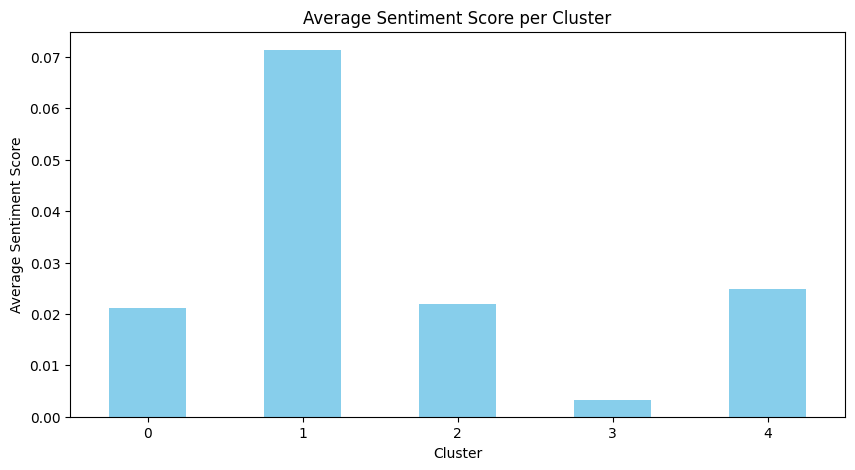

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame that includes 'sentiment_score' and 'cluster_label' columns
# Calculate the average sentiment for each cluster
average_sentiment_per_cluster = war_movies.groupby('topic')['sentiment_score'].mean()

# Plotting the results
plt.figure(figsize=(10, 5))
average_sentiment_per_cluster.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()